In [166]:
import numpy as np
import commpy as cp
import scipy.signal as sig
import scipy.linalg as la
import math
import matplotlib.pyplot as plt
%matplotlib inline

def modulate(data_bits, modulator):
    """  1. Modulates data bits (w/ c constellation points)"""
    return modulator.modulate(data_bits) 

def channel(input_data_constellations, channel_function):
    """  2. Convolves modulated data with a randomly generated channel fcn of t taps  """
    channel_output = sig.convolve(input_data_constellations, channel_function, mode='full') # convolve input complex data with the channel transfer function
    return channel_output

def noise(signal, amp):
    """  3. Add complex white Gaussian noise of specified amp"""
    noise = np.sqrt(amp/2) * np.random.randn(2, len(signal))
    return np.apply_over_axes(np.sum, np.stack((signal, noise[0], noise[1]*1j), axis=1), 1)

def LMS(signal, pre_channel_sig, L, mu=0.1):
    """  
    Returns a LMS equalizer w/ SGD. 
    Replaces expected error squared in MMSE with instantaneous error squared.
    """    
    order = 2*L + 1
    h = np.zeros(order, dtype=np.complex_)
    signal = np.pad(signal.flatten(), L, 'constant', constant_values=(0j))
    for i in range(len(pre_channel_sig)):
        r = np.flip(signal[i: i+order],0)
        y = pre_channel_sig[i]
        h = h + mu * (y - np.dot(r, h)) * r.conj() #not too sure about complex derivatives...
    return h 

# def MMSE(signal, pre_channel_sym, order, mu = 1):
#     """  
#     Computes empirical averages of the auto correlation matrix R and the cross correlation vector d
#     Solves the equation Rh = d
#     """    
#     def compute_auto_corr_mat(r_matrix):
#         R = np.zeros((order, order),dtype=np.complex_)
#         for row in r_matrix:
#             r = row.reshape(order, 1)
#             R += np.matmul(r, r.conj().T)
#         R = R / len(r_matrix)
#         return R
#     def compute_cross_corr_vec(r_matrix, pre_channel_sym):
#         I = np.diag(pre_channel_sym)
#         return np.average(np.matmul(I, r_matrix),0)
#     signal = np.pad(signal.flatten(), L, 'constant', constant_values=(0j))
#     r_matrix = []
#     for i in range(len(pre_channel_sym)):
#         r_matrix += [np.flip(signal[i: i+order],0)]
#     r_matrix = np.array(r_matrix) #[len(signal)-order+1]x[order] matrix
#     R = compute_auto_corr_mat(r_matrix)
#     d = compute_cross_corr_vec(r_matrix, pre_channel_sym)
#     return np.linalg.solve(R, d)
    
def predict(signal, eq_fcn, L):
    """ 4. Equalize the test signal"""
    return sig.convolve(signal, eq_fcn , mode="full")[L:]
    
def bit_err(in_bits, equalized_constellation, modulator):
    out_bits = modulator.demodulate(equalized_constellation, "hard")
    total = 0
    for i in range(len(in_bits)):
        if in_bits[i] != out_bits[i]:
            total += 1
    return total

def test(params={'channel_length':2, 'equalizer_L':2, 'noise_amplitude':1, 'preamble_length':100, 'test_length':int(1e3), 'mu':0.01, 'algo':MMSE}, runs=1):
    num_constellations = 4
    modulator = cp.modulation.QAMModem(num_constellations)
    avg_baseline_error = 0.
    avg_test_error = 0.
    for i in range(runs):
        # generate normalized channel function of consecutive taps
        channel_function = np.random.randn(params['channel_length']) 
        channel_function = channel_function / np.linalg.norm(channel_function)
        # generate bits
        preamble_bits = np.random.randint(0,2, params['preamble_length']) 
        test_bits = np.random.randint(0,2, params['test_length'])

        i = modulate(preamble_bits, modulator)
        r = noise(channel(i, channel_function), params['noise_amplitude'])
        i_test = modulate(test_bits, modulator)
        r_test = noise(channel(i_test, channel_function), params['noise_amplitude']).flatten()
        avg_baseline_error += bit_err(test_bits, r_test, modulator)
        
        h =  params['algo'](r, i, params['equalizer_L'], params['mu'])  
        test_pred = predict(r_test, h, params['equalizer_L'])
        avg_test_error += bit_err(test_bits, test_pred, modulator)
    
    return [avg_baseline_error/ (params['test_length']*runs), avg_test_error/ (params['test_length']*runs)] 


def plot_metric(metric_name, metric_range, semi_log=False, runs=1000,
                base_params={'channel_length':2, 'equalizer_L':2, 'noise_amplitude':0.2, 'preamble_length':100, 'test_length':int(1e3), 'mu':0.05, 'algo':MMSE}):
    np.random.seed(0)
    params = base_params.copy()    # copy to not overwrite default dictionary
    for algo in [('LMS', LMS)]:    #('MMSE', MMSE), 
        plot_baseline_errors = []
        plot_test_errors = []
        params['algo'] = algo[1]
        for i in metric_range:
            params[metric_name] = i
            baseline_err, test_err = test(params, runs=runs)
            plot_baseline_errors.append(baseline_err)
            plot_test_errors.append(test_err)
        if semi_log:
            plt.semilogx(metric_range, plot_baseline_errors, label=algo[0]+': baseline')
            plt.semilogx(metric_range, plot_test_errors, label=algo[0]+': test')
        else:
            plt.plot(metric_range, plot_baseline_errors, label=algo[0]+': baseline')
            plt.plot(metric_range, plot_test_errors, label=algo[0]+': test')
    plt.title(metric_name.upper()+" vs Avg. bit errors over "+str(runs)+" runs")
    plt.xlabel(metric_name.upper())
    plt.ylabel("Avg. # bit errors")
    plt.legend()
    plt.show()

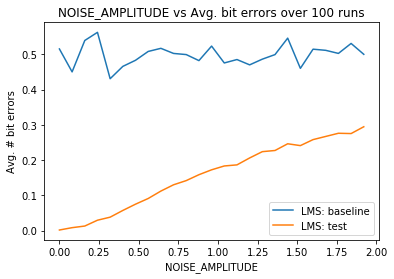

In [167]:
# plot metric: noise amplitude
amps = np.arange(0, 2, 0.08)
plot_metric("noise_amplitude", amps , runs=100)

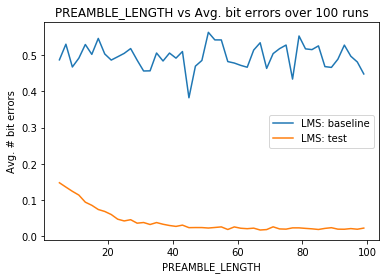

In [168]:
# plot metric: preamble length
preambles = np.arange(5, 100, 2)
plot_metric("preamble_length", preambles, runs=100)

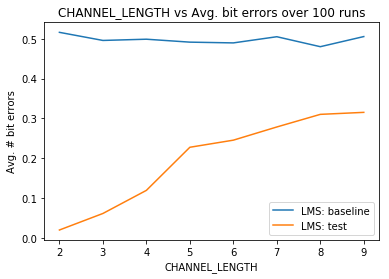

In [171]:
# plot metric: channel length
channels = np.arange(2, 10, 1)
plot_metric("channel_length", channels , runs=100)